# NB10: Statistical Significance Tests

**Question:** Are the performance differences we observe statistically significant?

This notebook produces thesis-ready results:
1. **Paired bootstrap tests** for key comparisons (RAG vs Direct, reranker impact, etc.)
2. **Wilcoxon signed-rank tests** as non-parametric alternative
3. **Multiple comparison correction** (Holm-Bonferroni)
4. **LaTeX tables** for direct inclusion in thesis

In [1]:
print(1)

1


In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as scipy_stats
from itertools import combinations

from analysis_utils import (
    load_all_results, load_per_item_scores, setup_plotting,
    compute_per_question_rag_delta, effect_size,
    PRIMARY_METRIC, BROKEN_MODELS, MODEL_TIER, MODEL_PARAMS,
    MULTI_METRIC_SET, CORRECTNESS_METRICS, CONTEXT_METRICS,
    GROUNDEDNESS_METRICS,
)

setup_plotting()
np.random.seed(42)

STUDY_PATH = Path("../outputs/smart_retrieval_slm")
ALPHA = 0.05  # Significance level
N_BOOTSTRAP = 10_000  # Bootstrap iterations

# Load experiment-level results
df_all = load_all_results(STUDY_PATH)
df = df_all[~df_all['model_short'].isin(BROKEN_MODELS)].copy()
df['tier'] = df['model_short'].map(MODEL_TIER)
df['params_b'] = df['model_short'].map(MODEL_PARAMS)

rag = df[df['exp_type'] == 'rag'].copy()
direct = df[df['exp_type'] == 'direct'].copy()

print(f"Total experiments: {len(df)} ({len(rag)} RAG, {len(direct)} direct)")
print(f"Models: {sorted(df['model_short'].unique())}")
print(f"Datasets: {sorted(df['dataset'].unique())}")

# Identify metrics available for multi-metric significance testing
sig_metrics = [m for m in MULTI_METRIC_SET
               if m in df.columns and df[m].notna().sum() >= 20]
print(f"\nMetrics available for significance tests: {sig_metrics}")


  343 experiment(s) use configs outside the current YAML.
  Consider adding these to your study config to explore them:
    • model: 42 exps — Phi-3-mini
    • query_transform: 314 exps — iterative
  Deduplicated: dropped 241 duplicate experiments (same effective config, kept best F1)
Total experiments: 710 (668 RAG, 42 direct)
Models: ['Gemma2-2B', 'Gemma2-9B', 'Llama-3.2-3B', 'Mistral-7B', 'Qwen2.5-1.5B', 'Qwen2.5-3B', 'Qwen2.5-7B']
Datasets: ['hotpotqa', 'nq', 'triviaqa']

Metrics available for significance tests: ['f1', 'exact_match', 'bertscore_f1', 'faithfulness', 'answer_in_context', 'context_recall']


## Statistical Test Functions

Paired bootstrap and Wilcoxon tests with Holm-Bonferroni correction.

In [3]:
def paired_bootstrap_test(a: np.ndarray, b: np.ndarray, n_bootstrap: int = N_BOOTSTRAP,
                          seed: int = 42) -> dict:
    """Paired bootstrap test: is mean(b) > mean(a)?

    Returns dict with observed_diff, ci_low, ci_high, p_value.
    """
    rng = np.random.default_rng(seed)
    assert len(a) == len(b), f"Paired test requires equal lengths: {len(a)} vs {len(b)}"

    observed_diff = np.mean(b) - np.mean(a)
    diffs = b - a

    boot_diffs = np.empty(n_bootstrap)
    for i in range(n_bootstrap):
        idx = rng.choice(len(diffs), size=len(diffs), replace=True)
        boot_diffs[i] = np.mean(diffs[idx])

    ci_low = np.percentile(boot_diffs, 2.5)
    ci_high = np.percentile(boot_diffs, 97.5)

    # Two-sided p-value: proportion of bootstrap samples on the other side of 0
    if observed_diff >= 0:
        p_value = np.mean(boot_diffs <= 0) * 2
    else:
        p_value = np.mean(boot_diffs >= 0) * 2
    p_value = min(p_value, 1.0)

    return {
        'observed_diff': observed_diff,
        'ci_low': ci_low,
        'ci_high': ci_high,
        'p_value': p_value,
        'n': len(a),
    }


def unpaired_bootstrap_test(a: np.ndarray, b: np.ndarray, n_bootstrap: int = N_BOOTSTRAP,
                            seed: int = 42) -> dict:
    """Unpaired bootstrap test: is mean(b) > mean(a)?"""
    rng = np.random.default_rng(seed)
    observed_diff = np.mean(b) - np.mean(a)

    boot_diffs = np.empty(n_bootstrap)
    for i in range(n_bootstrap):
        boot_a = rng.choice(a, size=len(a), replace=True)
        boot_b = rng.choice(b, size=len(b), replace=True)
        boot_diffs[i] = np.mean(boot_b) - np.mean(boot_a)

    ci_low = np.percentile(boot_diffs, 2.5)
    ci_high = np.percentile(boot_diffs, 97.5)

    if observed_diff >= 0:
        p_value = np.mean(boot_diffs <= 0) * 2
    else:
        p_value = np.mean(boot_diffs >= 0) * 2
    p_value = min(p_value, 1.0)

    return {
        'observed_diff': observed_diff,
        'ci_low': ci_low,
        'ci_high': ci_high,
        'p_value': p_value,
        'n_a': len(a),
        'n_b': len(b),
    }


def holm_bonferroni(p_values: list[float], alpha: float = ALPHA) -> list[dict]:
    """Apply Holm-Bonferroni correction to a list of p-values.

    Returns list of dicts with original_p, adjusted_p, significant.
    """
    n = len(p_values)
    indexed = sorted(enumerate(p_values), key=lambda x: x[1])

    results = [None] * n
    for rank, (orig_idx, p) in enumerate(indexed):
        adjusted = p * (n - rank)
        adjusted = min(adjusted, 1.0)
        results[orig_idx] = {
            'original_p': p,
            'adjusted_p': adjusted,
            'significant': adjusted < alpha,
        }

    return results


def significance_stars(p: float) -> str:
    """Return significance stars for a p-value."""
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'


def format_ci(diff, ci_low, ci_high, decimals=3) -> str:
    """Format difference with CI for display."""
    return f"{diff:+.{decimals}f} [{ci_low:+.{decimals}f}, {ci_high:+.{decimals}f}]"


print("Statistical test functions defined.")

Statistical test functions defined.


## 1. RAG vs Direct Baseline

For each model x dataset pair, compare the best RAG config against the best direct baseline.
Uses unpaired bootstrap since RAG and direct have different numbers of experiments.

In [4]:
# RAG vs Direct: per model x dataset
rag_vs_direct_rows = []

for model in sorted(df['model_short'].unique()):
    for dataset in sorted(df['dataset'].unique()):
        d_vals = direct[(direct['model_short'] == model) & (direct['dataset'] == dataset)][PRIMARY_METRIC].dropna().values
        r_vals = rag[(rag['model_short'] == model) & (rag['dataset'] == dataset)][PRIMARY_METRIC].dropna().values

        if len(d_vals) < 1 or len(r_vals) < 2:
            continue

        result = unpaired_bootstrap_test(d_vals, r_vals)

        # Also compute Wilcoxon if enough samples
        if len(r_vals) >= 5:
            # Mann-Whitney U (unpaired non-parametric)
            u_stat, mwu_p = scipy_stats.mannwhitneyu(r_vals, d_vals, alternative='two-sided')
        else:
            mwu_p = np.nan

        d_cohen, _, interp = effect_size(d_vals, r_vals)

        rag_vs_direct_rows.append({
            'model': model,
            'tier': MODEL_TIER.get(model, 'unknown'),
            'dataset': dataset,
            'direct_mean': np.mean(d_vals),
            'rag_mean': np.mean(r_vals),
            'diff': result['observed_diff'],
            'ci_low': result['ci_low'],
            'ci_high': result['ci_high'],
            'p_boot': result['p_value'],
            'p_mwu': mwu_p,
            'cohens_d': d_cohen,
            'effect': interp,
            'n_direct': len(d_vals),
            'n_rag': len(r_vals),
        })

rvd = pd.DataFrame(rag_vs_direct_rows)

if not rvd.empty:
    # Apply Holm-Bonferroni correction
    corrections = holm_bonferroni(rvd['p_boot'].tolist())
    rvd['p_adjusted'] = [c['adjusted_p'] for c in corrections]
    rvd['sig'] = [significance_stars(c['adjusted_p']) for c in corrections]

    print("RAG vs Direct: Per Model x Dataset")
    print("=" * 80)
    display(rvd[['model', 'tier', 'dataset', 'direct_mean', 'rag_mean', 'diff',
                 'ci_low', 'ci_high', 'p_adjusted', 'sig', 'cohens_d', 'effect']].round(4))

    # Summary: how often does RAG significantly help?
    n_sig_help = ((rvd['sig'] != 'ns') & (rvd['diff'] > 0)).sum()
    n_sig_hurt = ((rvd['sig'] != 'ns') & (rvd['diff'] < 0)).sum()
    n_ns = (rvd['sig'] == 'ns').sum()
    print(f"\nRAG significantly helps: {n_sig_help}/{len(rvd)} combos")
    print(f"RAG significantly hurts: {n_sig_hurt}/{len(rvd)} combos")
    print(f"No significant difference: {n_ns}/{len(rvd)} combos")

RAG vs Direct: Per Model x Dataset


,model,tier,dataset,direct_mean,rag_mean,diff,ci_low,ci_high,p_adjusted,sig,cohens_d,effect
0,Gemma2-2B,tiny,hotpotqa,0.1452,0.1639,0.0187,-0.0134,0.0496,1.0000,ns,0.2464,small
1,Gemma2-2B,tiny,nq,0.1838,0.2562,0.0724,0.0363,0.1061,0.0000,***,0.9808,large
2,Gemma2-2B,tiny,triviaqa,0.4530,0.4749,0.0220,-0.0136,0.0550,1.0000,ns,0.2366,small
3,Gemma2-9B,medium,hotpotqa,0.2905,0.2622,-0.0283,-0.0593,0.0016,1.0000,ns,-0.4641,small
4,Gemma2-9B,medium,nq,0.3728,0.3497,-0.0231,-0.0575,0.0061,1.0000,ns,-0.2879,small
5,Gemma2-9B,medium,triviaqa,0.6449,0.5716,-0.0733,-0.1455,-0.0153,0.0510,ns,-0.4114,small
6,Llama-3.2-3B,small,hotpotqa,0.1858,0.1638,-0.0221,-0.0511,0.0063,1.0000,ns,-0.3260,small
7,Llama-3.2-3B,small,nq,0.2715,0.2584,-0.0131,-0.0492,0.0197,1.0000,ns,-0.1442,negligible
8,Llama-3.2-3B,small,triviaqa,0.5762,0.3815,-0.1947,-0.2706,-0.1201,0.0000,***,-0.8744,large
9,Mistral-7B,medium,hotpotqa,0.1936,0.2485,0.0549,-0.0591,0.1680,1.0000,ns,0.8826,large



RAG significantly helps: 2/21 combos
RAG significantly hurts: 2/21 combos
No significant difference: 17/21 combos


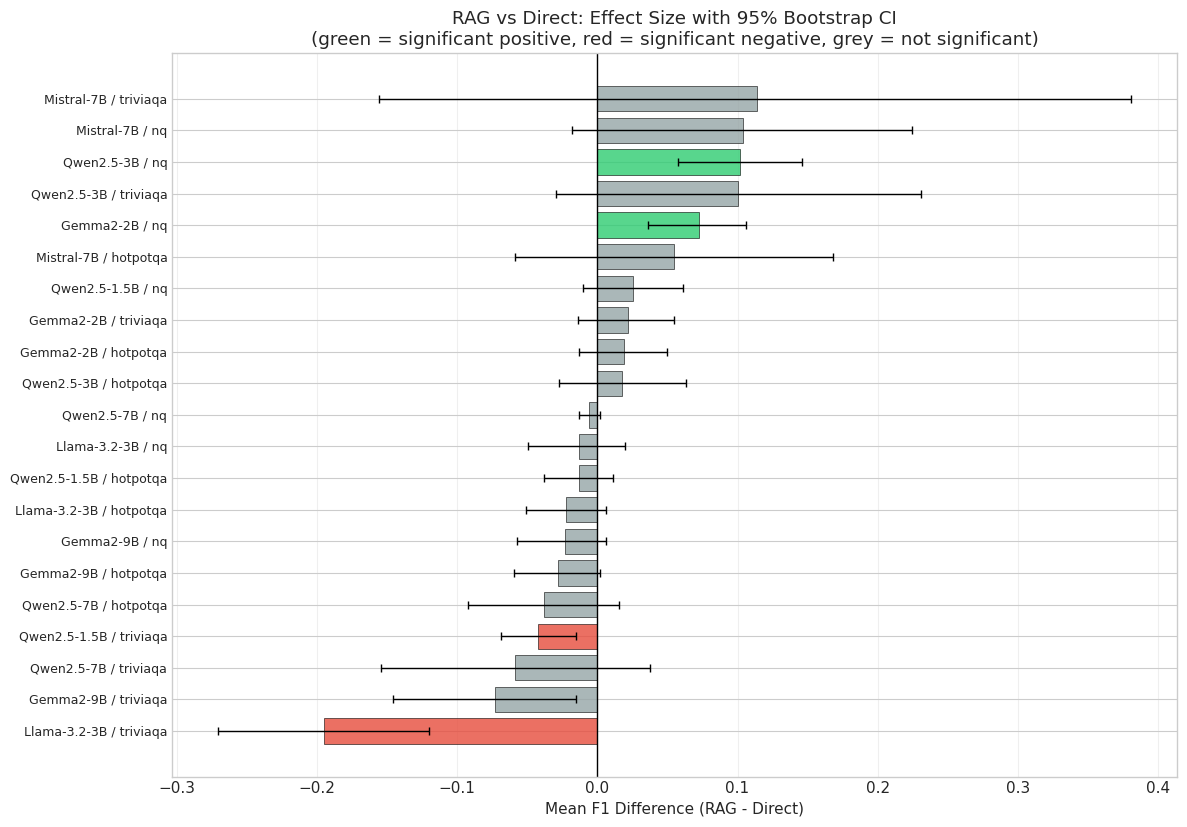

In [5]:
# Visualize RAG vs Direct effect sizes
if not rvd.empty:
    fig, ax = plt.subplots(figsize=(12, max(4, len(rvd) * 0.4)))

    rvd_sorted = rvd.sort_values('diff')
    y_labels = rvd_sorted['model'] + ' / ' + rvd_sorted['dataset']
    y_pos = range(len(rvd_sorted))

    colors = ['#2ecc71' if d > 0 and s != 'ns' else '#e74c3c' if d < 0 and s != 'ns' else '#95a5a6'
              for d, s in zip(rvd_sorted['diff'], rvd_sorted['sig'])]

    ax.barh(y_pos, rvd_sorted['diff'], color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
    ax.errorbar(rvd_sorted['diff'].values, y_pos,
                xerr=[rvd_sorted['diff'].values - rvd_sorted['ci_low'].values,
                      rvd_sorted['ci_high'].values - rvd_sorted['diff'].values],
                fmt='none', color='black', capsize=3, linewidth=1)

    ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(y_labels, fontsize=9)
    ax.set_xlabel(f'Mean {PRIMARY_METRIC.upper()} Difference (RAG - Direct)')
    ax.set_title('RAG vs Direct: Effect Size with 95% Bootstrap CI\n'
                 '(green = significant positive, red = significant negative, grey = not significant)')
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

## 2. Reranker Impact

Pairwise comparisons: none vs bge vs bge-v2, controlling for model and dataset.

In [6]:
# Reranker pairwise comparisons — stratified by dataset
reranker_levels = sorted(rag['reranker'].dropna().unique())
datasets = sorted(rag['dataset'].unique())
reranker_rows = []

for a_level, b_level in combinations(reranker_levels, 2):
    per_ds_diffs = []
    per_ds_d = []
    ds_details = []

    for ds in datasets:
        a_vals = rag[(rag['reranker'] == a_level) & (rag['dataset'] == ds)][PRIMARY_METRIC].dropna().values
        b_vals = rag[(rag['reranker'] == b_level) & (rag['dataset'] == ds)][PRIMARY_METRIC].dropna().values
        if len(a_vals) < 2 or len(b_vals) < 2:
            continue
        per_ds_diffs.append(np.mean(b_vals) - np.mean(a_vals))
        d_val, _, _ = effect_size(a_vals, b_vals)
        per_ds_d.append(d_val)
        ds_details.append({'dataset': ds, 'diff': per_ds_diffs[-1], 'd': d_val,
                           'n_a': len(a_vals), 'n_b': len(b_vals)})

    if not per_ds_diffs:
        continue

    # Combined: average per-dataset differences, bootstrap across datasets
    a_all = rag[rag['reranker'] == a_level][PRIMARY_METRIC].dropna().values
    b_all = rag[rag['reranker'] == b_level][PRIMARY_METRIC].dropna().values
    result = unpaired_bootstrap_test(a_all, b_all)
    d_cohen, _, interp = effect_size(a_all, b_all)

    reranker_rows.append({
        'baseline': a_level,
        'treatment': b_level,
        'baseline_mean': np.mean([np.mean(rag[(rag['reranker'] == a_level) & (rag['dataset'] == ds)][PRIMARY_METRIC].dropna())
                                  for ds in datasets if len(rag[(rag['reranker'] == a_level) & (rag['dataset'] == ds)][PRIMARY_METRIC].dropna()) > 0]),
        'treatment_mean': np.mean([np.mean(rag[(rag['reranker'] == b_level) & (rag['dataset'] == ds)][PRIMARY_METRIC].dropna())
                                   for ds in datasets if len(rag[(rag['reranker'] == b_level) & (rag['dataset'] == ds)][PRIMARY_METRIC].dropna()) > 0]),
        'diff': np.mean(per_ds_diffs),
        'ci_low': result['ci_low'],
        'ci_high': result['ci_high'],
        'p_boot': result['p_value'],
        'cohens_d': np.mean(per_ds_d),
        'effect': interp,
        'n_baseline': len(a_all),
        'n_treatment': len(b_all),
        'per_dataset': ds_details,
    })

rr_df = pd.DataFrame(reranker_rows)
if not rr_df.empty:
    corrections = holm_bonferroni(rr_df['p_boot'].tolist())
    rr_df['p_adjusted'] = [c['adjusted_p'] for c in corrections]
    rr_df['sig'] = [significance_stars(c['adjusted_p']) for c in corrections]

    print("Reranker Pairwise Comparisons (dataset-stratified)")
    print("=" * 80)
    display(rr_df[['baseline', 'treatment', 'baseline_mean', 'treatment_mean',
                   'diff', 'ci_low', 'ci_high', 'p_adjusted', 'sig',
                   'cohens_d', 'effect']].round(4))

    # Per-dataset breakdown
    for _, row in rr_df.iterrows():
        print(f"\n  {row['treatment']} vs {row['baseline']} per dataset:")
        for d in row['per_dataset']:
            print(f"    {d['dataset']:<12s}: diff={d['diff']:+.4f}, d={d['d']:+.3f} (n={d['n_a']}+{d['n_b']})")

Reranker Pairwise Comparisons (dataset-stratified)


,baseline,treatment,baseline_mean,treatment_mean,diff,ci_low,ci_high,p_adjusted,sig,cohens_d,effect
0,bge,bge-v2,0.2319,0.2329,0.0010,-0.0406,0.0451,1.0000,ns,0.0495,negligible
1,bge,none,0.2319,0.2406,0.0086,-0.0518,0.0491,0.9802,ns,0.1348,negligible
2,bge-v2,none,0.2329,0.2406,0.0077,-0.0401,0.0302,1.0000,ns,0.0806,negligible



  bge-v2 vs bge per dataset:
    hotpotqa    : diff=+0.0140, d=+0.146 (n=25+171)
    nq          : diff=+0.0164, d=+0.127 (n=34+151)
    triviaqa    : diff=-0.0275, d=-0.124 (n=27+170)

  none vs bge per dataset:
    hotpotqa    : diff=+0.0190, d=+0.190 (n=25+34)
    nq          : diff=+0.0496, d=+0.408 (n=34+33)
    triviaqa    : diff=-0.0428, d=-0.193 (n=27+23)

  none vs bge-v2 per dataset:
    hotpotqa    : diff=+0.0051, d=+0.053 (n=171+34)
    nq          : diff=+0.0332, d=+0.259 (n=151+33)
    triviaqa    : diff=-0.0153, d=-0.071 (n=170+23)


## 3. Agent Type Comparisons

Pairwise: fixed_rag vs iterative_rag vs self_rag.

In [7]:
# Agent type pairwise comparisons — stratified by dataset
agent_levels = sorted(rag['agent_type'].dropna().unique())
agent_rows = []

for a_level, b_level in combinations(agent_levels, 2):
    per_ds_diffs = []
    per_ds_d = []
    ds_details = []

    for ds in datasets:
        a_vals = rag[(rag['agent_type'] == a_level) & (rag['dataset'] == ds)][PRIMARY_METRIC].dropna().values
        b_vals = rag[(rag['agent_type'] == b_level) & (rag['dataset'] == ds)][PRIMARY_METRIC].dropna().values
        if len(a_vals) < 2 or len(b_vals) < 2:
            continue
        per_ds_diffs.append(np.mean(b_vals) - np.mean(a_vals))
        d_val, _, _ = effect_size(a_vals, b_vals)
        per_ds_d.append(d_val)
        ds_details.append({'dataset': ds, 'diff': per_ds_diffs[-1], 'd': d_val,
                           'n_a': len(a_vals), 'n_b': len(b_vals)})

    if not per_ds_diffs:
        continue

    a_all = rag[rag['agent_type'] == a_level][PRIMARY_METRIC].dropna().values
    b_all = rag[rag['agent_type'] == b_level][PRIMARY_METRIC].dropna().values
    result = unpaired_bootstrap_test(a_all, b_all)
    d_cohen, _, interp = effect_size(a_all, b_all)

    agent_rows.append({
        'baseline': a_level,
        'treatment': b_level,
        'baseline_mean': np.mean([np.mean(rag[(rag['agent_type'] == a_level) & (rag['dataset'] == ds)][PRIMARY_METRIC].dropna())
                                  for ds in datasets if len(rag[(rag['agent_type'] == a_level) & (rag['dataset'] == ds)][PRIMARY_METRIC].dropna()) > 0]),
        'treatment_mean': np.mean([np.mean(rag[(rag['agent_type'] == b_level) & (rag['dataset'] == ds)][PRIMARY_METRIC].dropna())
                                   for ds in datasets if len(rag[(rag['agent_type'] == b_level) & (rag['dataset'] == ds)][PRIMARY_METRIC].dropna()) > 0]),
        'diff': np.mean(per_ds_diffs),
        'ci_low': result['ci_low'],
        'ci_high': result['ci_high'],
        'p_boot': result['p_value'],
        'cohens_d': np.mean(per_ds_d),
        'effect': interp,
        'n_baseline': len(a_all),
        'n_treatment': len(b_all),
        'per_dataset': ds_details,
    })

agent_df = pd.DataFrame(agent_rows)
if not agent_df.empty:
    corrections = holm_bonferroni(agent_df['p_boot'].tolist())
    agent_df['p_adjusted'] = [c['adjusted_p'] for c in corrections]
    agent_df['sig'] = [significance_stars(c['adjusted_p']) for c in corrections]

    print("Agent Type Pairwise Comparisons (dataset-stratified)")
    print("=" * 80)
    display(agent_df[['baseline', 'treatment', 'baseline_mean', 'treatment_mean',
                      'diff', 'ci_low', 'ci_high', 'p_adjusted', 'sig',
                      'cohens_d', 'effect']].round(4))

    for _, row in agent_df.iterrows():
        print(f"\n  {row['treatment']} vs {row['baseline']} per dataset:")
        for d in row['per_dataset']:
            print(f"    {d['dataset']:<12s}: diff={d['diff']:+.4f}, d={d['d']:+.3f} (n={d['n_a']}+{d['n_b']})")

Agent Type Pairwise Comparisons (dataset-stratified)


,baseline,treatment,baseline_mean,treatment_mean,diff,ci_low,ci_high,p_adjusted,sig,cohens_d,effect
0,fixed_rag,iterative_rag,0.2374,0.2372,-0.0002,-0.0358,0.0316,0.9300,ns,0.0079,negligible
1,fixed_rag,self_rag,0.2374,0.2254,-0.0120,-0.0511,0.0231,0.9468,ns,-0.1082,negligible
2,iterative_rag,self_rag,0.2372,0.2254,-0.0118,-0.0429,0.0196,1.0000,ns,-0.1144,negligible



  iterative_rag vs fixed_rag per dataset:
    hotpotqa    : diff=-0.0066, d=-0.067 (n=51+110)
    nq          : diff=+0.0210, d=+0.159 (n=50+109)
    triviaqa    : diff=-0.0151, d=-0.068 (n=51+106)

  self_rag vs fixed_rag per dataset:
    hotpotqa    : diff=-0.0129, d=-0.140 (n=51+69)
    nq          : diff=-0.0217, d=-0.177 (n=50+59)
    triviaqa    : diff=-0.0016, d=-0.007 (n=51+63)

  self_rag vs iterative_rag per dataset:
    hotpotqa    : diff=-0.0062, d=-0.064 (n=110+69)
    nq          : diff=-0.0427, d=-0.340 (n=109+59)
    triviaqa    : diff=+0.0136, d=+0.061 (n=106+63)


## 4. Query Transform Impact

Pairwise: none vs hyde vs multiquery.

In [8]:
# Query transform pairwise comparisons — stratified by dataset
qt_levels = sorted(rag['query_transform'].dropna().unique())
qt_rows = []

for a_level, b_level in combinations(qt_levels, 2):
    per_ds_diffs = []
    per_ds_d = []
    ds_details = []

    for ds in datasets:
        a_vals = rag[(rag['query_transform'] == a_level) & (rag['dataset'] == ds)][PRIMARY_METRIC].dropna().values
        b_vals = rag[(rag['query_transform'] == b_level) & (rag['dataset'] == ds)][PRIMARY_METRIC].dropna().values
        if len(a_vals) < 2 or len(b_vals) < 2:
            continue
        per_ds_diffs.append(np.mean(b_vals) - np.mean(a_vals))
        d_val, _, _ = effect_size(a_vals, b_vals)
        per_ds_d.append(d_val)
        ds_details.append({'dataset': ds, 'diff': per_ds_diffs[-1], 'd': d_val,
                           'n_a': len(a_vals), 'n_b': len(b_vals)})

    if not per_ds_diffs:
        continue

    a_all = rag[rag['query_transform'] == a_level][PRIMARY_METRIC].dropna().values
    b_all = rag[rag['query_transform'] == b_level][PRIMARY_METRIC].dropna().values
    result = unpaired_bootstrap_test(a_all, b_all)
    d_cohen, _, interp = effect_size(a_all, b_all)

    qt_rows.append({
        'baseline': a_level,
        'treatment': b_level,
        'baseline_mean': np.mean([np.mean(rag[(rag['query_transform'] == a_level) & (rag['dataset'] == ds)][PRIMARY_METRIC].dropna())
                                  for ds in datasets if len(rag[(rag['query_transform'] == a_level) & (rag['dataset'] == ds)][PRIMARY_METRIC].dropna()) > 0]),
        'treatment_mean': np.mean([np.mean(rag[(rag['query_transform'] == b_level) & (rag['dataset'] == ds)][PRIMARY_METRIC].dropna())
                                   for ds in datasets if len(rag[(rag['query_transform'] == b_level) & (rag['dataset'] == ds)][PRIMARY_METRIC].dropna()) > 0]),
        'diff': np.mean(per_ds_diffs),
        'ci_low': result['ci_low'],
        'ci_high': result['ci_high'],
        'p_boot': result['p_value'],
        'cohens_d': np.mean(per_ds_d),
        'effect': interp,
        'n_baseline': len(a_all),
        'n_treatment': len(b_all),
        'per_dataset': ds_details,
    })

qt_df = pd.DataFrame(qt_rows)
if not qt_df.empty:
    corrections = holm_bonferroni(qt_df['p_boot'].tolist())
    qt_df['p_adjusted'] = [c['adjusted_p'] for c in corrections]
    qt_df['sig'] = [significance_stars(c['adjusted_p']) for c in corrections]

    print("Query Transform Pairwise Comparisons (dataset-stratified)")
    print("=" * 80)
    display(qt_df[['baseline', 'treatment', 'baseline_mean', 'treatment_mean',
                   'diff', 'ci_low', 'ci_high', 'p_adjusted', 'sig',
                   'cohens_d', 'effect']].round(4))

    for _, row in qt_df.iterrows():
        print(f"\n  {row['treatment']} vs {row['baseline']} per dataset:")
        for d in row['per_dataset']:
            print(f"    {d['dataset']:<12s}: diff={d['diff']:+.4f}, d={d['d']:+.3f} (n={d['n_a']}+{d['n_b']})")

Query Transform Pairwise Comparisons (dataset-stratified)


,baseline,treatment,baseline_mean,treatment_mean,diff,ci_low,ci_high,p_adjusted,sig,cohens_d,effect
0,hyde,iterative,0.2301,0.2345,0.0044,-0.0240,0.0663,1.0000,ns,0.0831,negligible
1,hyde,multiquery,0.2301,0.2411,0.0110,-0.0112,0.0836,0.7620,ns,0.0898,small
2,hyde,none,0.2301,0.2311,0.0010,-0.0296,0.0575,1.0000,ns,0.0238,negligible
3,iterative,multiquery,0.2345,0.2411,0.0066,-0.0228,0.0532,1.0000,ns,0.0063,negligible
4,iterative,none,0.2345,0.2311,-0.0034,-0.0393,0.0260,0.6956,ns,-0.0632,negligible
5,multiquery,none,0.2411,0.2311,-0.0100,-0.0595,0.0144,1.0000,ns,-0.0666,negligible



  iterative vs hyde per dataset:
    hotpotqa    : diff=+0.0137, d=+0.136 (n=32+64)
    nq          : diff=+0.0350, d=+0.271 (n=31+66)
    triviaqa    : diff=-0.0355, d=-0.158 (n=21+64)

  multiquery vs hyde per dataset:
    hotpotqa    : diff=-0.0068, d=-0.067 (n=32+48)
    nq          : diff=+0.0480, d=+0.374 (n=31+46)
    triviaqa    : diff=-0.0082, d=-0.037 (n=21+59)

  none vs hyde per dataset:
    hotpotqa    : diff=+0.0066, d=+0.070 (n=32+86)
    nq          : diff=+0.0052, d=+0.041 (n=31+75)
    triviaqa    : diff=-0.0087, d=-0.039 (n=21+76)

  multiquery vs iterative per dataset:
    hotpotqa    : diff=-0.0205, d=-0.208 (n=64+48)
    nq          : diff=+0.0130, d=+0.102 (n=66+46)
    triviaqa    : diff=+0.0272, d=+0.124 (n=64+59)

  none vs iterative per dataset:
    hotpotqa    : diff=-0.0071, d=-0.076 (n=64+86)
    nq          : diff=-0.0299, d=-0.236 (n=66+75)
    triviaqa    : diff=+0.0268, d=+0.122 (n=64+76)

  none vs multiquery per dataset:
    hotpotqa    : diff=+0.01

## 5. Model Tier Comparisons

Tiny (1-2B) vs Small (3B) vs Medium (7-9B) on RAG experiments.

In [9]:
# Model tier pairwise comparisons — stratified by dataset
rag_with_tier = rag.dropna(subset=['tier']).copy()
tier_levels = ['tiny', 'small', 'medium']
tier_rows = []

for a_tier, b_tier in combinations(tier_levels, 2):
    per_ds_diffs = []
    per_ds_d = []
    ds_details = []

    for ds in datasets:
        a_vals = rag_with_tier[(rag_with_tier['tier'] == a_tier) & (rag_with_tier['dataset'] == ds)][PRIMARY_METRIC].dropna().values
        b_vals = rag_with_tier[(rag_with_tier['tier'] == b_tier) & (rag_with_tier['dataset'] == ds)][PRIMARY_METRIC].dropna().values
        if len(a_vals) < 2 or len(b_vals) < 2:
            continue
        per_ds_diffs.append(np.mean(b_vals) - np.mean(a_vals))
        d_val, _, _ = effect_size(a_vals, b_vals)
        per_ds_d.append(d_val)
        ds_details.append({'dataset': ds, 'diff': per_ds_diffs[-1], 'd': d_val,
                           'n_a': len(a_vals), 'n_b': len(b_vals)})

    if not per_ds_diffs:
        continue

    a_all = rag_with_tier[rag_with_tier['tier'] == a_tier][PRIMARY_METRIC].dropna().values
    b_all = rag_with_tier[rag_with_tier['tier'] == b_tier][PRIMARY_METRIC].dropna().values
    result = unpaired_bootstrap_test(a_all, b_all)
    d_cohen, _, interp = effect_size(a_all, b_all)

    tier_rows.append({
        'baseline': a_tier,
        'treatment': b_tier,
        'baseline_mean': np.mean([np.mean(rag_with_tier[(rag_with_tier['tier'] == a_tier) & (rag_with_tier['dataset'] == ds)][PRIMARY_METRIC].dropna())
                                  for ds in datasets if len(rag_with_tier[(rag_with_tier['tier'] == a_tier) & (rag_with_tier['dataset'] == ds)][PRIMARY_METRIC].dropna()) > 0]),
        'treatment_mean': np.mean([np.mean(rag_with_tier[(rag_with_tier['tier'] == b_tier) & (rag_with_tier['dataset'] == ds)][PRIMARY_METRIC].dropna())
                                   for ds in datasets if len(rag_with_tier[(rag_with_tier['tier'] == b_tier) & (rag_with_tier['dataset'] == ds)][PRIMARY_METRIC].dropna()) > 0]),
        'diff': np.mean(per_ds_diffs),
        'ci_low': result['ci_low'],
        'ci_high': result['ci_high'],
        'p_boot': result['p_value'],
        'cohens_d': np.mean(per_ds_d),
        'effect': interp,
        'n_baseline': len(a_all),
        'n_treatment': len(b_all),
        'per_dataset': ds_details,
    })

tier_df = pd.DataFrame(tier_rows)
if not tier_df.empty:
    corrections = holm_bonferroni(tier_df['p_boot'].tolist())
    tier_df['p_adjusted'] = [c['adjusted_p'] for c in corrections]
    tier_df['sig'] = [significance_stars(c['adjusted_p']) for c in corrections]

    print("Model Tier Comparisons — RAG only (dataset-stratified)")
    print("=" * 80)
    display(tier_df[['baseline', 'treatment', 'baseline_mean', 'treatment_mean',
                     'diff', 'ci_low', 'ci_high', 'p_adjusted', 'sig',
                     'cohens_d', 'effect']].round(4))

    # Per-dataset breakdown
    for _, row in tier_df.iterrows():
        print(f"\n  {row['treatment']} vs {row['baseline']} per dataset:")
        for d in row['per_dataset']:
            print(f"    {d['dataset']:<12s}: diff={d['diff']:+.4f}, d={d['d']:+.3f} (n={d['n_a']}+{d['n_b']})")

Model Tier Comparisons — RAG only (dataset-stratified)


,baseline,treatment,baseline_mean,treatment_mean,diff,ci_low,ci_high,p_adjusted,sig,cohens_d,effect
0,tiny,small,0.2168,0.2106,-0.0062,-0.0388,0.0214,0.5838,ns,-0.0157,negligible
1,tiny,medium,0.2168,0.2636,0.0468,0.0126,0.0778,0.0120,*,0.3718,small
2,small,medium,0.2106,0.2636,0.0530,0.0217,0.0861,0.0012,**,0.3841,small



  small vs tiny per dataset:
    hotpotqa    : diff=-0.0026, d=-0.035 (n=67+69)
    nq          : diff=+0.0163, d=+0.163 (n=61+69)
    triviaqa    : diff=-0.0324, d=-0.176 (n=66+65)

  medium vs tiny per dataset:
    hotpotqa    : diff=+0.0626, d=+0.646 (n=67+94)
    nq          : diff=+0.0430, d=+0.314 (n=61+88)
    triviaqa    : diff=+0.0348, d=+0.155 (n=66+89)

  medium vs small per dataset:
    hotpotqa    : diff=+0.0652, d=+0.673 (n=69+94)
    nq          : diff=+0.0266, d=+0.194 (n=69+88)
    triviaqa    : diff=+0.0673, d=+0.285 (n=65+89)


## 6. Best RAG vs Best Direct (Per Model x Dataset)

The most relevant thesis comparison: does the *best* RAG config beat the *best* direct config?

In [10]:
best_comparison_rows = []

for model in sorted(df['model_short'].unique()):
    for dataset in sorted(df['dataset'].unique()):
        d_sub = direct[(direct['model_short'] == model) & (direct['dataset'] == dataset)]
        r_sub = rag[(rag['model_short'] == model) & (rag['dataset'] == dataset)]

        d_vals = d_sub[PRIMARY_METRIC].dropna()
        r_vals = r_sub[PRIMARY_METRIC].dropna()

        if d_vals.empty or r_vals.empty:
            continue

        best_direct = d_vals.max()
        best_rag = r_vals.max()

        # Top-5 RAG mean as a more robust estimate
        top5_rag = r_vals.nlargest(min(5, len(r_vals))).mean()

        best_comparison_rows.append({
            'model': model,
            'tier': MODEL_TIER.get(model, 'unknown'),
            'dataset': dataset,
            'best_direct': best_direct,
            'best_rag': best_rag,
            'top5_rag_mean': top5_rag,
            'rag_advantage': best_rag - best_direct,
            'rag_advantage_pct': (best_rag - best_direct) / best_direct * 100 if best_direct > 0 else np.nan,
            'n_rag_configs': len(r_vals),
        })

best_df = pd.DataFrame(best_comparison_rows)
if not best_df.empty:
    print("Best RAG vs Best Direct (per model x dataset)")
    print("=" * 80)
    display(best_df.round(4))

    n_rag_wins = (best_df['rag_advantage'] > 0).sum()
    print(f"\nRAG beats direct: {n_rag_wins}/{len(best_df)} combos")
    print(f"Mean RAG advantage: {best_df['rag_advantage'].mean():+.4f} F1")
    print(f"Mean RAG advantage: {best_df['rag_advantage_pct'].mean():+.1f}%")

    # By tier
    print("\nBy model tier:")
    for tier in ['tiny', 'small', 'medium']:
        t_df = best_df[best_df['tier'] == tier]
        if not t_df.empty:
            wins = (t_df['rag_advantage'] > 0).sum()
            print(f"  {tier}: RAG wins {wins}/{len(t_df)}, "
                  f"mean advantage {t_df['rag_advantage'].mean():+.4f}")

Best RAG vs Best Direct (per model x dataset)


,model,tier,dataset,best_direct,best_rag,top5_rag_mean,rag_advantage,rag_advantage_pct,n_rag_configs
0,Gemma2-2B,tiny,hotpotqa,0.1571,0.2530,0.2425,0.0959,61.0210,30
1,Gemma2-2B,tiny,nq,0.1997,0.3483,0.3272,0.1486,74.4367,28
2,Gemma2-2B,tiny,triviaqa,0.4648,0.5713,0.5659,0.1065,22.9225,36
3,Gemma2-9B,medium,hotpotqa,0.3069,0.3305,0.3234,0.0236,7.6773,30
4,Gemma2-9B,medium,nq,0.3808,0.4283,0.4126,0.0475,12.4764,28
5,Gemma2-9B,medium,triviaqa,0.6457,0.6777,0.6696,0.0321,4.9657,28
6,Llama-3.2-3B,small,hotpotqa,0.1995,0.2355,0.2311,0.0359,18.0070,37
7,Llama-3.2-3B,small,nq,0.2815,0.3670,0.3459,0.0855,30.3660,32
8,Llama-3.2-3B,small,triviaqa,0.5855,0.5989,0.5918,0.0134,2.2888,34
9,Mistral-7B,medium,hotpotqa,0.2939,0.3053,0.2998,0.0114,3.8761,32



RAG beats direct: 20/21 combos
Mean RAG advantage: +0.0719 F1
Mean RAG advantage: +44.3%

By model tier:
  tiny: RAG wins 6/6, mean advantage +0.1184
  small: RAG wins 6/6, mean advantage +0.0828
  medium: RAG wins 8/9, mean advantage +0.0337


## 7. Consolidated Summary Table

In [11]:
# Build a consolidated summary of all comparisons (dataset-stratified)
summary_rows = []

# RAG vs Direct overall
if not rvd.empty:
    summary_rows.append({
        'comparison': 'RAG vs Direct (all)',
        'mean_diff': rvd['diff'].mean(),
        'n_significant': (rvd['sig'] != 'ns').sum(),
        'n_total': len(rvd),
        'median_d': rvd['cohens_d'].median(),
        'direction': 'RAG better' if rvd['diff'].mean() > 0 else 'Direct better',
    })

# Reranker
if not rr_df.empty:
    for _, row in rr_df.iterrows():
        summary_rows.append({
            'comparison': f'Reranker: {row["treatment"]} vs {row["baseline"]}',
            'mean_diff': row['diff'],
            'n_significant': 1 if row['sig'] != 'ns' else 0,
            'n_total': 1,
            'median_d': row['cohens_d'],
            'direction': f'{row["treatment"]} better' if row['diff'] > 0 else f'{row["baseline"]} better',
        })

# Agent types
if not agent_df.empty:
    for _, row in agent_df.iterrows():
        summary_rows.append({
            'comparison': f'Agent: {row["treatment"]} vs {row["baseline"]}',
            'mean_diff': row['diff'],
            'n_significant': 1 if row['sig'] != 'ns' else 0,
            'n_total': 1,
            'median_d': row['cohens_d'],
            'direction': f'{row["treatment"]} better' if row['diff'] > 0 else f'{row["baseline"]} better',
        })

# Query transform
if not qt_df.empty:
    for _, row in qt_df.iterrows():
        summary_rows.append({
            'comparison': f'QT: {row["treatment"]} vs {row["baseline"]}',
            'mean_diff': row['diff'],
            'n_significant': 1 if row['sig'] != 'ns' else 0,
            'n_total': 1,
            'median_d': row['cohens_d'],
            'direction': f'{row["treatment"]} better' if row['diff'] > 0 else f'{row["baseline"]} better',
        })

# Model tiers
if not tier_df.empty:
    for _, row in tier_df.iterrows():
        summary_rows.append({
            'comparison': f'Tier: {row["treatment"]} vs {row["baseline"]}',
            'mean_diff': row['diff'],
            'n_significant': 1 if row['sig'] != 'ns' else 0,
            'n_total': 1,
            'median_d': row['cohens_d'],
            'direction': f'{row["treatment"]} better' if row['diff'] > 0 else f'{row["baseline"]} better',
        })

summary_df = pd.DataFrame(summary_rows)
if not summary_df.empty:
    print("Consolidated Significance Summary (dataset-stratified)")
    print("=" * 80)
    display(summary_df.round(4))

Consolidated Significance Summary (dataset-stratified)


,comparison,mean_diff,n_significant,n_total,median_d,direction
0,RAG vs Direct (all),0.0056,4,21,-0.1442,RAG better
1,Reranker: bge-v2 vs bge,0.0010,0,1,0.0495,bge-v2 better
2,Reranker: none vs bge,0.0086,0,1,0.1348,none better
3,Reranker: none vs bge-v2,0.0077,0,1,0.0806,none better
4,Agent: iterative_rag vs fixed_rag,-0.0002,0,1,0.0079,fixed_rag better
5,Agent: self_rag vs fixed_rag,-0.0120,0,1,-0.1082,fixed_rag better
6,Agent: self_rag vs iterative_rag,-0.0118,0,1,-0.1144,iterative_rag better
7,QT: iterative vs hyde,0.0044,0,1,0.0831,iterative better
8,QT: multiquery vs hyde,0.0110,0,1,0.0898,multiquery better
9,QT: none vs hyde,0.0010,0,1,0.0238,none better


## 7b. Multi-Metric Significance: Do All Metrics Agree?

Run key comparisons across all available metrics. If RAG significantly helps on F1
but not on faithfulness, or if reranker matters for exact_match but not context_recall,
that reveals important nuances.

Multi-Metric Significance Summary — dataset-stratified


metric,answer_in_context,bertscore_f1,context_recall,exact_match,f1,faithfulness
comparison,,,,,,
QT: hyde vs none,***,ns,***,ns,ns,NaN
RAG vs Direct,NaN,ns,NaN,ns,ns,ns
Reranker: bge-v2 vs none,ns,ns,*,ns,ns,NaN
Tier: medium vs tiny,ns,ns,ns,**,**,NaN



Effect Sizes (Cohen's d, averaged across datasets):


metric,answer_in_context,bertscore_f1,context_recall,exact_match,f1,faithfulness
comparison,,,,,,
QT: hyde vs none,0.58,0.29,0.57,-0.02,-0.02,NaN
RAG vs Direct,NaN,-0.32,NaN,-0.02,0.04,0.59
Reranker: bge-v2 vs none,0.14,0.08,0.23,-0.07,-0.08,NaN
Tier: medium vs tiny,-0.17,0.33,-0.14,0.41,0.37,NaN


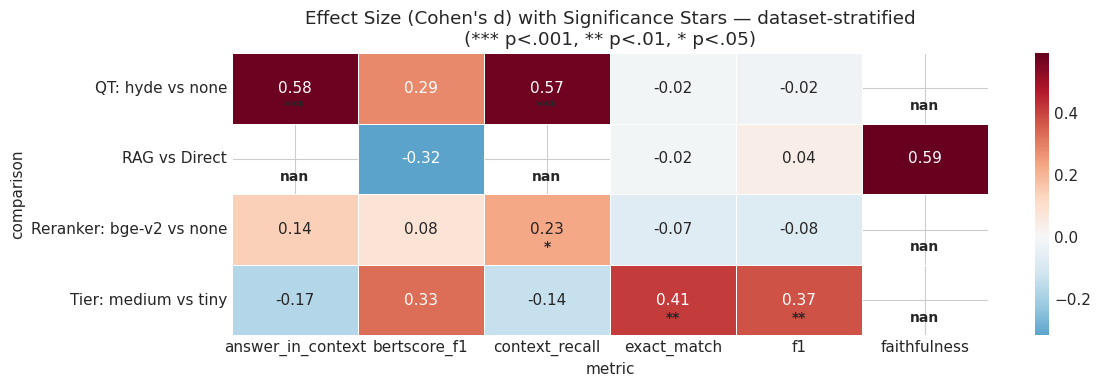


Metric Agreement Analysis:
  QT: hyde vs none:
    Significant: answer_in_context, context_recall, faithfulness
    NOT significant: bertscore_f1, exact_match, f1
  RAG vs Direct:
    Significant: answer_in_context, context_recall
    NOT significant: bertscore_f1, exact_match, f1, faithfulness
  Reranker: bge-v2 vs none:
    Significant: context_recall, faithfulness
    NOT significant: answer_in_context, bertscore_f1, exact_match, f1
  Tier: medium vs tiny:
    Significant: exact_match, f1, faithfulness
    NOT significant: answer_in_context, bertscore_f1, context_recall


In [12]:
# Multi-metric significance: key comparisons across all available metrics (per-dataset)
if len(sig_metrics) >= 2:
    # Define the key comparisons to test across metrics
    comparisons = []

    # 1. RAG vs Direct (overall)
    if len(direct) >= 3 and len(rag) >= 3:
        comparisons.append(('RAG vs Direct', 'exp_type', 'direct', 'rag', df))

    # 2. Reranker: bge-v2 vs none
    rr_none = rag[rag['reranker'] == 'none']
    rr_bgev2 = rag[rag['reranker'] == 'bge-v2']
    if len(rr_none) >= 3 and len(rr_bgev2) >= 3:
        comparisons.append(('Reranker: bge-v2 vs none', 'reranker', 'none', 'bge-v2', rag))

    # 3. Model tier: medium vs tiny
    t_tiny = rag[rag['tier'] == 'tiny']
    t_medium = rag[rag['tier'] == 'medium']
    if len(t_tiny) >= 3 and len(t_medium) >= 3:
        comparisons.append(('Tier: medium vs tiny', 'tier', 'tiny', 'medium', rag))

    # 4. Query transform: none vs hyde
    qt_none = rag[rag['query_transform'] == 'none']
    qt_hyde = rag[rag['query_transform'] == 'hyde']
    if len(qt_none) >= 3 and len(qt_hyde) >= 3:
        comparisons.append(('QT: hyde vs none', 'query_transform', 'none', 'hyde', rag))

    # Run all comparisons across all metrics — stratified by dataset
    mm_rows = []
    for comp_name, factor_col, base_val, treat_val, source_df in comparisons:
        for metric in sig_metrics:
            # Per-dataset differences then average
            per_ds_diffs = []
            per_ds_d = []
            a_all_vals = []
            b_all_vals = []
            for ds in datasets:
                a_vals = source_df[(source_df[factor_col] == base_val) & (source_df['dataset'] == ds)][metric].dropna().values
                b_vals = source_df[(source_df[factor_col] == treat_val) & (source_df['dataset'] == ds)][metric].dropna().values
                if len(a_vals) < 2 or len(b_vals) < 2:
                    continue
                per_ds_diffs.append(np.mean(b_vals) - np.mean(a_vals))
                d_val, _, _ = effect_size(a_vals, b_vals)
                per_ds_d.append(d_val)
                a_all_vals.extend(a_vals)
                b_all_vals.extend(b_vals)

            a_all = np.array(a_all_vals)
            b_all = np.array(b_all_vals)
            if len(a_all) < 3 or len(b_all) < 3:
                continue

            result = unpaired_bootstrap_test(a_all, b_all, n_bootstrap=5000)
            d_cohen_avg = np.mean(per_ds_d) if per_ds_d else 0
            _, _, interp = effect_size(a_all, b_all)

            mm_rows.append({
                'comparison': comp_name,
                'metric': metric,
                'baseline_mean': np.mean([np.mean(source_df[(source_df[factor_col] == base_val) & (source_df['dataset'] == ds)][metric].dropna())
                                          for ds in datasets if len(source_df[(source_df[factor_col] == base_val) & (source_df['dataset'] == ds)][metric].dropna()) > 0]),
                'treatment_mean': np.mean([np.mean(source_df[(source_df[factor_col] == treat_val) & (source_df['dataset'] == ds)][metric].dropna())
                                           for ds in datasets if len(source_df[(source_df[factor_col] == treat_val) & (source_df['dataset'] == ds)][metric].dropna()) > 0]),
                'diff': np.mean(per_ds_diffs) if per_ds_diffs else result['observed_diff'],
                'ci_low': result['ci_low'],
                'ci_high': result['ci_high'],
                'p_value': result['p_value'],
                'cohens_d': d_cohen_avg,
                'effect': interp,
                'sig': significance_stars(result['p_value']),
            })

    mm_sig = pd.DataFrame(mm_rows)

    if not mm_sig.empty:
        sig_pivot = mm_sig.pivot(index='comparison', columns='metric', values='sig')
        diff_pivot = mm_sig.pivot(index='comparison', columns='metric', values='diff')

        print("Multi-Metric Significance Summary — dataset-stratified")
        print("=" * 80)
        display(sig_pivot)

        print("\nEffect Sizes (Cohen's d, averaged across datasets):")
        d_pivot = mm_sig.pivot(index='comparison', columns='metric', values='cohens_d')
        display(d_pivot.round(2))

        # Heatmap of effect sizes
        fig, ax = plt.subplots(figsize=(max(8, len(sig_metrics) * 2), max(4, len(comparisons) * 0.8)))
        sns.heatmap(d_pivot.astype(float), annot=True, fmt='.2f', cmap='RdBu_r',
                    center=0, ax=ax, linewidths=0.5)
        for i, comp in enumerate(d_pivot.index):
            for j, metric in enumerate(d_pivot.columns):
                star = sig_pivot.loc[comp, metric] if comp in sig_pivot.index and metric in sig_pivot.columns else ''
                if star and star != 'ns':
                    ax.text(j + 0.5, i + 0.75, star, ha='center', va='center',
                            fontsize=10, fontweight='bold')
        ax.set_title("Effect Size (Cohen's d) with Significance Stars — dataset-stratified\n"
                     "(*** p<.001, ** p<.01, * p<.05)")
        plt.tight_layout()
        plt.show()

        # Key insight: metric disagreements
        print("\nMetric Agreement Analysis:")
        for comp in sig_pivot.index:
            sigs = sig_pivot.loc[comp]
            sig_metrics_list = [m for m in sigs.index if sigs[m] != 'ns']
            ns_metrics_list = [m for m in sigs.index if sigs[m] == 'ns']
            if sig_metrics_list and ns_metrics_list:
                print(f"  {comp}:")
                print(f"    Significant: {', '.join(sig_metrics_list)}")
                print(f"    NOT significant: {', '.join(ns_metrics_list)}")
            elif not sig_metrics_list:
                print(f"  {comp}: NOT significant on any metric")
            else:
                print(f"  {comp}: Significant on ALL metrics")
else:
    print("Only one metric available; multi-metric analysis requires >= 2.")

## 8. LaTeX Tables

Publication-ready tables for direct inclusion in the thesis.

In [13]:
def df_to_latex(df, columns, col_names=None, caption="", label="",
                fmt=None, bold_col=None, bold_fn=None):
    """Convert a DataFrame to a LaTeX table string.

    Args:
        df: DataFrame to convert.
        columns: List of column names to include.
        col_names: Display names for columns (same length as columns).
        caption: LaTeX table caption.
        label: LaTeX table label.
        fmt: Dict mapping column names to format strings.
        bold_col: Column to apply bold formatting to.
        bold_fn: Function(value) -> bool; if True, bold that cell.
    """
    if col_names is None:
        col_names = columns
    if fmt is None:
        fmt = {}

    n_cols = len(columns)
    col_spec = 'l' + 'r' * (n_cols - 1)

    lines = [
        r'\begin{table}[htbp]',
        r'\centering',
        f'\\caption{{{caption}}}',
        f'\\label{{{label}}}',
        f'\\begin{{tabular}}{{{col_spec}}}',
        r'\toprule',
        ' & '.join(f'\\textbf{{{n}}}' for n in col_names) + r' \\',
        r'\midrule',
    ]

    for _, row in df.iterrows():
        cells = []
        for col in columns:
            val = row[col]
            if col in fmt and isinstance(val, (int, float)) and not pd.isna(val):
                cell = fmt[col].format(val)
            else:
                cell = str(val)
            # Escape underscores for LaTeX
            cell = cell.replace('_', r'\_')
            if bold_col and col == bold_col and bold_fn and bold_fn(val):
                cell = f'\\textbf{{{cell}}}'
            cells.append(cell)
        lines.append(' & '.join(cells) + r' \\')

    lines.extend([
        r'\bottomrule',
        r'\end{tabular}',
        r'\end{table}',
    ])

    return '\n'.join(lines)


# Table 1: RAG vs Direct per Model x Dataset
if not rvd.empty:
    latex1 = df_to_latex(
        rvd.sort_values(['tier', 'model', 'dataset']),
        columns=['model', 'dataset', 'direct_mean', 'rag_mean', 'diff', 'p_adjusted', 'sig', 'effect'],
        col_names=['Model', 'Dataset', 'Direct F1', 'RAG F1', '$\\Delta$', '$p_{adj}$', 'Sig.', 'Effect'],
        caption='RAG vs Direct LLM performance per model and dataset. '
                'P-values corrected with Holm-Bonferroni. Effect size: Cohen\'s d.',
        label='tab:rag-vs-direct',
        fmt={'direct_mean': '{:.3f}', 'rag_mean': '{:.3f}', 'diff': '{:+.3f}',
             'p_adjusted': '{:.4f}'},
        bold_col='sig',
        bold_fn=lambda v: v != 'ns',
    )
    print("% === Table 1: RAG vs Direct ===")
    print(latex1)
    print()

# Table 2: Component Impact Summary
component_rows = []
for label, comp_df in [('Reranker', rr_df), ('Agent Type', agent_df),
                       ('Query Transform', qt_df), ('Model Tier', tier_df)]:
    if comp_df is not None and not comp_df.empty:
        for _, row in comp_df.iterrows():
            component_rows.append({
                'component': label,
                'comparison': f"{row['treatment']} vs {row['baseline']}",
                'diff': row['diff'],
                'ci': f"[{row['ci_low']:+.3f}, {row['ci_high']:+.3f}]",
                'p_adjusted': row['p_adjusted'],
                'sig': row['sig'],
                'cohens_d': row['cohens_d'],
                'effect': row['effect'],
            })

comp_summary = pd.DataFrame(component_rows)
if not comp_summary.empty:
    latex2 = df_to_latex(
        comp_summary,
        columns=['component', 'comparison', 'diff', 'ci', 'p_adjusted', 'sig', 'effect'],
        col_names=['Component', 'Comparison', '$\\Delta$ F1', '95\\% CI',
                   '$p_{adj}$', 'Sig.', 'Effect'],
        caption='Pairwise component comparisons with bootstrap significance tests. '
                'All p-values Holm-Bonferroni corrected within each component group.',
        label='tab:component-significance',
        fmt={'diff': '{:+.3f}', 'p_adjusted': '{:.4f}', 'cohens_d': '{:.2f}'},
        bold_col='sig',
        bold_fn=lambda v: v != 'ns',
    )
    print("% === Table 2: Component Significance ===")
    print(latex2)
    print()

# Table 3: Best RAG vs Best Direct
if not best_df.empty:
    latex3 = df_to_latex(
        best_df.sort_values(['tier', 'model', 'dataset']),
        columns=['model', 'tier', 'dataset', 'best_direct', 'best_rag',
                 'rag_advantage', 'rag_advantage_pct'],
        col_names=['Model', 'Tier', 'Dataset', 'Best Direct', 'Best RAG',
                   '$\\Delta$ F1', '$\\Delta$ \\%'],
        caption='Best RAG configuration vs best direct LLM per model and dataset.',
        label='tab:best-rag-vs-direct',
        fmt={'best_direct': '{:.3f}', 'best_rag': '{:.3f}',
             'rag_advantage': '{:+.3f}', 'rag_advantage_pct': '{:+.1f}'},
        bold_col='rag_advantage',
        bold_fn=lambda v: isinstance(v, (int, float)) and v > 0,
    )
    print("% === Table 3: Best RAG vs Best Direct ===")
    print(latex3)

% === Table 1: RAG vs Direct ===
\begin{table}[htbp]
\centering
\caption{RAG vs Direct LLM performance per model and dataset. P-values corrected with Holm-Bonferroni. Effect size: Cohen's d.}
\label{tab:rag-vs-direct}
\begin{tabular}{lrrrrrrr}
\toprule
\textbf{Model} & \textbf{Dataset} & \textbf{Direct F1} & \textbf{RAG F1} & \textbf{$\Delta$} & \textbf{$p_{adj}$} & \textbf{Sig.} & \textbf{Effect} \\
\midrule
Gemma2-9B & hotpotqa & 0.290 & 0.262 & -0.028 & 1.0000 & ns & small \\
Gemma2-9B & nq & 0.373 & 0.350 & -0.023 & 1.0000 & ns & small \\
Gemma2-9B & triviaqa & 0.645 & 0.572 & -0.073 & 0.0510 & ns & small \\
Mistral-7B & hotpotqa & 0.194 & 0.249 & +0.055 & 1.0000 & ns & large \\
Mistral-7B & nq & 0.213 & 0.317 & +0.104 & 1.0000 & ns & large \\
Mistral-7B & triviaqa & 0.358 & 0.472 & +0.114 & 1.0000 & ns & medium \\
Qwen2.5-7B & hotpotqa & 0.089 & 0.051 & -0.038 & 1.0000 & ns & large \\
Qwen2.5-7B & nq & 0.043 & 0.037 & -0.006 & 1.0000 & ns & small \\
Qwen2.5-7B & triviaqa & 0.163 &

## 9. Summary

Key findings from statistical tests:
- Whether RAG significantly outperforms direct LLM (per model tier and dataset)
- Which components have statistically significant effects (reranker, agent, query transform)
- Effect sizes (Cohen's d) to quantify practical significance
- LaTeX tables ready for thesis inclusion